In [26]:

import numpy as np
import pandas as pd
from scipy import stats   # 이상치 처리를 위해서 필요
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import warnings

warnings.filterwarnings(action='ignore')  # warning 출력을 하지 않아요!

# Raw Data Loading
df = pd.read_csv('./data/ozone.csv')

taining_data = df

x_data = taining_data[['Solar.R','Wind','Temp']]
t_data = taining_data['Ozone']

# 결측치 확인
# 1. 독립변수에 대한 결측치 처리부터 하고 갈께요!!
#    Solar.R에 7개의 결측치가 있는데 median으로 처리할께요!
for col in x_data.columns:
    col_median = np.nanmedian(x_data[col])
    x_data[col].loc[x_data[col].isnull()] = col_median
    
# 2. 독립변수에 대한 이상치를 검출한 후 이 이상치는 mean처리할께요!
zscore = 1.8

for col in x_data.columns:
    outliers = x_data[col][np.abs(stats.zscore(x_data[col])) > zscore]
    col_mean = np.mean(x_data.loc[~x_data[col].isin(outliers),col])
    x_data.loc[x_data[col].isin(outliers),col] = col_mean

# 3. 정규화를 진행해요!

scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(x_data.values)
scaler_t.fit(t_data.values.reshape(-1,1))

x_data_norm = scaler_x.transform(x_data) # 2차원
t_data_norm = scaler_t.transform(t_data.values.reshape(-1,1)).ravel()
# 2차원 형태인데 나중에 1차원으로 사용되어야 해요..그래서 ravel() 사용.
    

# 4. 종속변수(Ozone)에 대한 결측치는 KNN을 이용해서 예측값으로 imputation할 꺼예요!
#    학습에 사용될 x_data_train_norm , t_data_train_norm을 구해야 해요!
x_data_train_norm = x_data_norm[~np.isnan(t_data_norm)]
t_data_train_norm = t_data_norm[~np.isnan(t_data_norm)]

# KNN 모델 생성 후 학습진행
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(x_data_train_norm,t_data_train_norm)

# knn_predict
knn_predict = knn_regressor.predict(x_data_norm[np.isnan(t_data_norm)])
t_data_norm[np.isnan(t_data_norm)] = knn_predict

# 최종 데이터를 생성했어요!
# x_data_norm
# t_data_norm

##########################################
# 학습을 진행해 보아요! Linear Regression

from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

test_data = [[310, 15, 80]]  # 테스트 데이터!! Ozone 량을 예측해 보아요!

# sklearn
sklearn_model = LinearRegression()
sklearn_model.fit(x_data_norm,t_data_norm)
result = sklearn_model.predict(scaler_x.transform(test_data)).reshape(-1,1)

scaled_result = scaler_t.inverse_transform(result)
print('sklearn의 결과 : {}'.format(scaled_result))

# Tensorflow 2.x
# 모델생성
keras_model = Sequential()
# 레이어 추가
keras_model.add(Flatten(input_shape=(3,)))  # input layer
keras_model.add(Dense(1, activation='linear'))  # output layer

# compile
keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                    loss='mse')

# 학습
keras_model.fit(x_data_norm,
                t_data_norm,
                epochs=5000,
                verbose=0)

#prediction
result = keras_model.predict(scaler_x.transform(test_data)).reshape(-1,1)

scaled_result = scaler_t.inverse_transform(result)
print('tensorflow의 결과 : {}'.format(scaled_result))


sklearn의 결과 : [[38.75927452]]
tensorflow의 결과 : [[38.659718]]


In [37]:
## Logistic Regression에 대해서 sklearn과 Tensorflow 2.x 구현을 
## 해볼꺼예요!!
## titanic(kaggle) => logistic문제 (결측치가 다수있어요!!)
## feature engineering

## 데이터를 완전히 준비하는건 여러분들이 해보세요!
## 데이터 준비가 끝나면 저랑같이 구현하는 부분만 해 보아요!!

%reset

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats

# Raw Data Loading
df = pd.read_csv('./data/titanic/train.csv')

# Feature Engineering

# 필요없는 column 삭제

df = df.drop(['PassengerId','Name','Ticket','Cabin','Fare'], axis=1, inplace=False)

# 하나로 합칠 수 있는 column 처리
df['Family'] = df['SibSp'] + df['Parch']
df.drop(['SibSp','Parch'], axis=1, inplace=True)

# 문자로 되어 있는 column을 숫자로 변환
sex_dict = { 'male' : 0, 'female' : 1 }
df['Sex'] = df['Sex'].map(sex_dict)

embarked_dict = {'S' : 0, 'C' : 1, 'Q' : 2}
df['Embarked'] = df['Embarked'].map(embarked_dict)

# # 결측치 처리
# Age에 177개의 결측치, Embarked에 결측치 2
# Age는 median, Embarked는 mode를 이용하여 결측치 처리
df.loc[df['Age'].isnull(),'Age'] = np.nanmedian(df['Age'].values)

mode_result = stats.mode(df['Embarked'],nan_policy='omit')[0].ravel()
# print('mode_result : {}'.format(mode_result))
df.loc[df['Embarked'].isnull(),'Embarked'] = mode_result[0]
print(df.isnull().sum())

# 이상치 확인
# zscore = 1.8

# for col in df.columns:
#     outliers = df.loc[np.abs(stats.zscore(df[col])) >= zscore,col]
#     print('Col : {}에 이상치 : {}개'.format(col,outliers.sum()))
#     print('outliers : {}'.format(outliers))
# 실제로 이상치가 검출되지만 사실값이기 때문에 수정하지 않음.

def age_category(age):
    if ((age >=0) & (age<25)):
        return 0
    elif ((age >=25) & (age<50)):
        return 1
    else:
        return 2

df['Age'] = df['Age'].map(age_category)    

#################################################

df
# data split

x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('Survived', axis=1, inplace=False), df['Survived'], test_size=0.3, random_state=0)

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

del x_data_train
del x_data_test

##################

# sklearn으로 모델 구현
sklearn_model = LogisticRegression()    # model 생성
sklearn_model.fit(x_data_train_norm,t_data_train)  # model 학습
sklearn_result = sklearn_model.score(x_data_test_norm,t_data_test)

print('sklearn의 정확도는 : {}'.format(sklearn_result))

# tensorflow 2.x로 구현
keras_model = Sequential()

keras_model.add(Flatten(input_shape=(x_data_train_norm.shape[1],)))
keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(optimizer=SGD(learning_rate=1e-3),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

result = keras_model.fit(x_data_train_norm,
                         t_data_train,
                         epochs=1000,
                         verbose=0,
                         validation_split=0.3)

keras_result = keras_model.evaluate(x_data_test_norm,t_data_test)
print('TF2.0의 정확도는 : {}'.format(keras_result))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Survived    0
Pclass      0
Sex         0
Age         0
Embarked    0
Family      0
dtype: int64
sklearn의 정확도는 : 0.7947761194029851
268/268 [==============================] - 0s 37us/sample - loss: 0.5203 - accuracy: 0.8022
TF2.0의 정확도는 : [0.5203279514810932, 0.8022388]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


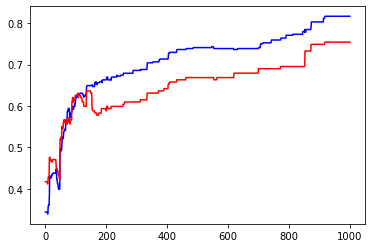

In [39]:
import matplotlib.pyplot as plt

print(result.history.keys())

plt.plot(result.history['accuracy'], color='b')
plt.plot(result.history['val_accuracy'], color='r')
plt.show()

In [43]:
# Multinomial Classification에 대해서
# sklearn과 TF 2.x의 구현을 해 보아요!
# MNIST예제를 이용해서 구현해 보아요!!!

%reset

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression  # multinomial 구현도 이걸 이용
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Raw Data Loading
df = pd.read_csv('./data/mnist/train.csv')

# 결측치나 이상치는 없어요!!
# Feature Engineering 할 필요가 없어요!!

# 독립변수와 종속변수 분리
x_data = df.drop('label', axis=1, inplace=False)
t_data = df['label']   # one-hot encoding해야하는데 일단 안할꺼예요!!

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

# Data Split
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(x_data_norm,t_data,test_size=0.3, random_state=0)

# 데이터 준비가 끝났어요!! 이제 학습을 진행해 보아요!
sklearn_model = LogisticRegression(solver='saga')
# solver라는 개념이 있는데 default로 사용되는건 lbfgs라는 놈이예요!
# lbfgs : 작은 데이터셋에 좋아요!, 데이터량이 많으면 성능이 별로예요!
# 데이터량이 많은 경우 sag(Stochastic Average Gradient Descent)를 사용하면 더 좋아요
# 일반적으로 또 이걸 개량한 saga를 더 많이 이용해요!

sklearn_model.fit(x_data_train,t_data_train)  # 학습진행
print('sklearn result :')
print(classification_report(t_data_test, 
                            sklearn_model.predict(x_data_test)))

# TF 2.0 구현
keras_model = Sequential()
keras_model.add(Flatten(input_shape=(x_data_train.shape[1],)))
keras_model.add(Dense(10, activation='softmax'))

keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                    loss='sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy'])

history = keras_model.fit(x_data_train,
                          t_data_train,
                          epochs=500,
                          batch_size=100,
                          verbose=0,
                          validation_split=0.3)

print(keras_model.evaluate(x_data_test,t_data_test))
print('tensorflow result :')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
sklearn result :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1242
           1       0.95      0.97      0.96      1429
           2       0.92      0.90      0.91      1276
           3       0.91      0.90      0.90      1298
           4       0.92      0.92      0.92      1236
           5       0.88      0.88      0.88      1119
           6       0.93      0.96      0.94      1243
           7       0.94      0.93      0.94      1334
           8       0.89      0.88      0.88      1204
           9       0.89      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600

12600/12600 [==============================] - 0s 26us/sample - loss: 0.2886 - sparse_categorical_accuracy: 0.9204
[0.2885915385446851, 0.9203968]
tensorflow re

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1242
           1       0.96      0.97      0.97      1429
           2       0.93      0.90      0.91      1276
           3       0.91      0.89      0.90      1298
           4       0.92      0.92      0.92      1236
           5       0.89      0.88      0.88      1119
           6       0.92      0.96      0.94      1243
           7       0.94      0.92      0.93      1334
           8       0.89      0.88      0.89      1204
           9       0.88      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600



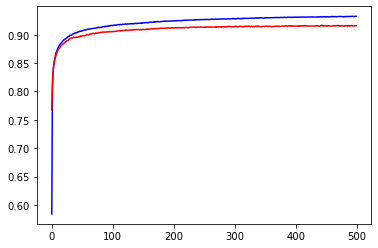

In [51]:
print(classification_report(t_data_test, 
                            (tf.argmax(keras_model.predict(x_data_test), axis=1)).numpy()))

# (tf.argmax(keras_model.predict(x_data_test), axis=1)).numpy()
import matplotlib.pyplot as plt

history.history.keys()
plt.plot(history.history['sparse_categorical_accuracy'], color='b')
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r')
plt.show()